# CNN 이진분류 (컬러 사진)
- cats and dogs 데이터셋
- 컬러이미지 사용
- 로컬PC에 저장되어있는 이미지 데이터를 로딩해서 학습시키기
- (옵션) GPU 사용
- 모델 작성 참고
  
```
https://github.com/raahatg21/Cats-and-Dogs-Dataset-with-Keras/blob/master/Cats_Dogs_9439.ipynb
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras

### 1.데이터 준비

```
!gdown https://drive.google.com/uc?id=1Zl5mt-tgrx3LOtk5dfYhYrqfRUVWRKdA
```

In [3]:
# 대용량인 경우 구글 드라이버에서 다운로드
# 또는 구글드라이버 마운트해서 사용해도 되지만..일단 다운로드해서 사용

!gdown https://drive.google.com/uc?id=1dC-Kso5FonYWtbxtJnJ8_dxO_Jlo8weR

Downloading...
From (original): https://drive.google.com/uc?id=1dC-Kso5FonYWtbxtJnJ8_dxO_Jlo8weR
From (redirected): https://drive.google.com/uc?id=1dC-Kso5FonYWtbxtJnJ8_dxO_Jlo8weR&confirm=t&uuid=924ef913-ab77-4b86-88db-cfd50238253a
To: /content/cats_and_dogs.zip
100% 68.6M/68.6M [00:02<00:00, 26.9MB/s]


In [4]:
!unzip -q 'cats_and_dogs.zip'

In [5]:
data_root = '/content/cats_and_dogs'
train_dir = data_root + '/train'
test_dir = data_root + '/test'

train_dir, test_dir

('/content/cats_and_dogs/train', '/content/cats_and_dogs/test')

```
많이 사용해왔던 ImageDataGenerator가 deprecated되어서,  
tf.keras.preprocessing.image.ImageDataGenerator()


- keras.utils.image_dataset_from_directory 사용법
https://www.tensorflow.org/tutorials/load_data/images?hl=ko
```

### image_dataset_from_directory() 사용법 참고

```
참고:
https://www.tensorflow.org/tutorials/load_data/images?hl=ko
```

In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
    #   color_mode = 'grayscale',  #흑백이면 사용하는가?
  batch_size=batch_size)

Found 2600 files belonging to 2 classes.
Using 2080 files for training.


In [8]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2600 files belonging to 2 classes.
Using 520 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


### 데이터 시각화

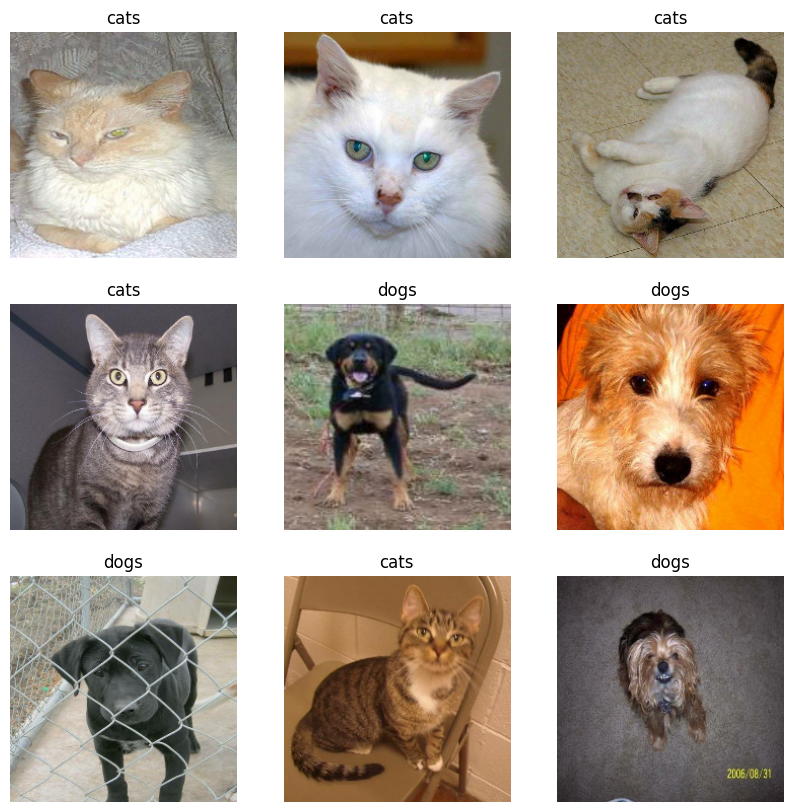

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# 이미지 정보 표시

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  # 텐서에서 numpy로 변경해서 표시하기
  print(labels_batch.shape, labels_batch.numpy())
  break

(32, 224, 224, 3)
(32,)
(32,) [1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1]


### 데이터 표준화하기
두가지 방법으로 할 수 있는데, 모델을 만들때 레이어에 추가해서 사용하는 방법으로 해보자
```
아래 레이어 추가
tf.keras.layers.Rescaling(1./255),
```

## 모델

In [13]:
# generate dummy data
input_dim = (224,224,3)

In [14]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(input_dim),
  tf.keras.layers.Rescaling(1./255),

  # CNN 모델
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9

In [16]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'])

## 모델 학습

In [17]:
EPOCHS = 1 #3

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

65/65 [==============================] - 148s 2s/step - loss: 0.7046 - accuracy: 0.5337 - val_loss: 0.6811 - val_accuracy: 0.5212


In [18]:
# 결과 그래프 그리기

## 예측 및 평가

### 테스트 데이터

In [19]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.


In [20]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### 평가

In [21]:
results = model.evaluate(test_ds)
results

13/13 [==============================] - 8s 527ms/step - loss: 0.6745 - accuracy: 0.5075


[0.6744946241378784, 0.5074999928474426]

In [22]:
# 전처리 및 학습 참고
# https://hwiyong.tistory.com/402

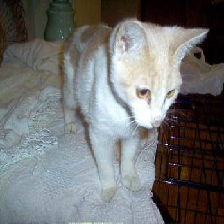

In [23]:
# 하나의 이미지를 테스트 함

img = keras.preprocessing.image.load_img(
    '/content/cats_and_dogs/test/cats/cat.2300.jpg',
    target_size=(img_height, img_width)
)

img

In [24]:
img_array = keras.preprocessing.image.img_to_array(img)

# 축추가 - 하나의 이미지를 예측하더라도 배치형태이어야 한다
# img_array = tf.expand_dims(img_array, 0)
img_array = img_array.reshape(-1, 224, 224, 3)  # Create batch axis
img_array.shape


(1, 224, 224, 3)

In [25]:
y_pred = model.predict(img_array)
score = y_pred[0]
score

# 0.5보다 작으면 고양이, 크면 강아지

1/1 [==============================] - 0s 137ms/step


array([0.5700182], dtype=float32)

# 이미지 증강 사용

```
https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko
https://hwiyong.tistory.com/402
```

In [32]:
# 전처리 레이어
from keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224, 224),
  layers.Rescaling(1./255),
], name='resize_rescaling')

In [33]:
# 데이터 증강 레이어를 구성한다.

data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        # layers.RandomZoom(0.2),
        # layers.RandomContrast(0.2),
        # layers.RandomBrightness(0.2),
        # layers.RandomTranslation(0.2, 0.2),
        # Add more data augmentation layers as needed

    ], name='augmentation'
)

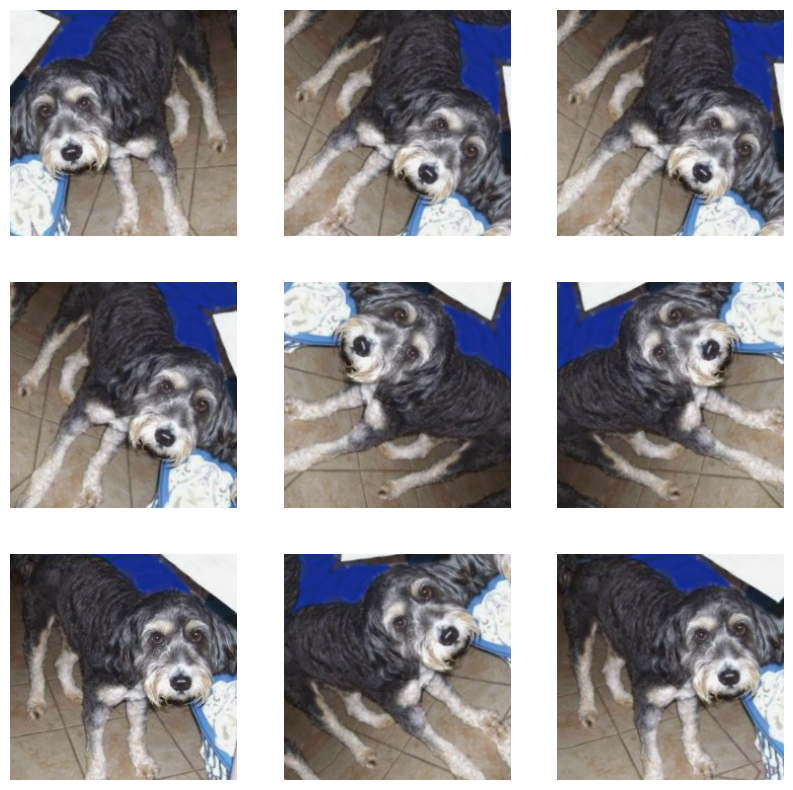

In [34]:
# 데이터 증강 시각화

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

-  모델에 데이터 증강을 사용하는 방법  
이 방법을 사용하면 테스트 데이터에도 그냥 별도의 처리없이 바로 예측에 적용할 수 있다.

```
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model

```

In [35]:
# generate dummy data
input_dim = (224,224,3)

In [36]:
from keras import layers

def build_model(input_shape):
    # 함수형API 모델을 작성할 때는 Input이 여기에 있어야 하네...
    inputs = layers.Input(shape=input_shape)

    # 본격적으로 모델에 입력하기 전에 여기서 augmentation이 진행됩니다.
    # inference time에는 동작하지 않습니다.
    x = data_augmentation(inputs)
    x = resize_and_rescale(x)
    # [0, 1] 변환을 위해 Rescaling Layer를 활용합니다.
    x = layers.Rescaling(1.0 / 255)(x)

    # CNN 모델
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    #  x = layers.GlobalAveragePooling2D()(x) 를 사용할 수도 있슴
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

In [37]:
# 이 모델은 서머리를 보기위해서는 빌드를 해야한다.
model = build_model(input_dim)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resize_rescaling (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                        

## 모델 학습

In [38]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [39]:
EPOCHS = 3

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/3
65/65 [==============================] - 148s 2s/step - loss: 0.6934 - accuracy: 0.4870 - val_loss: 0.6931 - val_accuracy: 0.5058
Epoch 2/3
65/65 [==============================] - 141s 2s/step - loss: 0.6932 - accuracy: 0.4899 - val_loss: 0.6932 - val_accuracy: 0.4942
Epoch 3/3
65/65 [==============================] - 147s 2s/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.4942


## 예측 및 평가

```
참고
https://hwiyong.tistory.com/402
```

In [40]:
# inference time에는 Dropout과 data augmentation이 비활성화 상태가 됩니다.
# 하지만 Rescaling layer는 그대로 활용되기 때문에 테스트용 데이터로 추론을
# 진행할 때 올바른 결과를 얻을 수 있습니다.

In [41]:
results = model.evaluate(test_ds)
results

13/13 [==============================] - 8s 604ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931484341621399, 0.5]

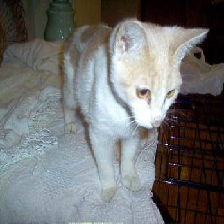

In [42]:
# 한개의 이미지를 예측한다

img = keras.preprocessing.image.load_img(
    '/content/cats_and_dogs/test/cats/cat.2300.jpg',
    target_size=(img_height, img_width)
)

img

In [43]:
img_array = keras.preprocessing.image.img_to_array(img)

# 축추가 - 하나의 이미지를 예측하더라도 배치형태이어야 한다
# img_array = tf.expand_dims(img_array, 0)
img_array = img_array.reshape(-1, 224, 224, 3)  # Create batch axis
img_array.shape


(1, 224, 224, 3)

In [44]:
y_pred = model.predict(img_array)
score = y_pred[0]
score

# 0.5보다 작으면 고양이, 크면 강아지

1/1 [==============================] - 0s 104ms/step


array([0.49920672], dtype=float32)

# END